In [1]:
import datetime
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
def log_transform_custom(ts):
    ts = np.log(ts)
    ts[ts==-np.inf] = 0
    ts[ts==np.nan] = 0
    
    return ts

In [4]:
calendar_df = pd.read_csv('만든데이터/calendar.csv')
calendar_dict = calendar_df.set_index('date').to_dict('index')
calendar_df.head()

,date,weekday,is_weekend,is_holiday,week_index,year
0,20190126,토,True,False,-1,2019
1,20190127,일,True,False,-1,2019
2,20190128,월,False,False,0,2019
3,20190129,화,False,False,0,2019
4,20190130,수,False,False,0,2019


In [5]:
def attach_week_info_into_df(df, date_column):
    df['is_holiday'] = [calendar_dict[date]['is_weekend'] or calendar_dict[date]['is_holiday'] for date in df[date_column]]
    df['week_index'] = [calendar_dict[date]['week_index'] for date in df[date_column]]
    df['year'] = [calendar_dict[date]['year'] for date in df[date_column]]

In [6]:
week_info_days = {}

for i, row in calendar_df.iterrows():
    is_holiday = row['is_weekend'] or row['is_holiday']
    week_info_days[row['year'], row['week_index'], is_holiday] = week_info_days.get((row['year'], row['week_index'], is_holiday), 0) + 1

In [7]:
dong_code = pd.read_csv('만든데이터/dong_code.csv')

dong_code_to_name = {
    (row['구코드'], row['행정동코드']): (row['구명'], row['행정동명']) 
    for i, row in dong_code.iterrows()
}

dong_to_sido = {
    row['행정동명']: row['구명'].split(' ')[0]
    for i, row in dong_code.iterrows()
}

def convert_dong_code_to_name(*codes):
    if len(codes) == 2:
        gu_code, dong_conde = codes
        if gu_code < 100:
            gu_code = gu_code * 10
    elif len(codes) == 1 and isdecimal(codes[0]):
        code = str(codes[0])
        gu_code = code[2:5]
        dong_code = code[5:8]
    else:
        raise ValueError('행정구 코드, 행정동 코드 140, 520 으로 이루어져있거나 1114052000 와 같은 형태여야 합니다')

    return dong_code_to_name[gu_code, dong_conde]

In [8]:
dong_to_sido = {
    row['행정동명']: row['구명'].split(' ')[0]
    for i, row in dong_code.iterrows()
}

In [9]:
seoul_dong_names = dong_code[dong_code['구명'].isin({'서울 중구', '서울 노원구'})]['행정동명'].to_list()
daegu_dong_names = dong_code[dong_code['구명'].isin({'대구 중구', '대구 수성구'})]['행정동명'].to_list()

len(seoul_dong_names), len(daegu_dong_names)

(34, 35)

# 코로나 확진자수 데이터

In [10]:
corona_df = pd.read_csv('외부데이터/코로나(캐글 등)/TimeProvince.csv')
corona_df['date'] = corona_df['date'].str.replace('-', '')
corona_df['date'] = corona_df['date'].astype(int)
corona_df = corona_df[corona_df['province'].isin({'Seoul', 'Daegu'})] 
corona_df = corona_df[(20200119 <= corona_df['date']) & (corona_df['date'] <= 20200531)]
corona_df = corona_df[['date', 'province', 'confirmed']]

corona_df.tail()

,date,province,confirmed
2212,20200529,Daegu,6880
2227,20200530,Seoul,855
2229,20200530,Daegu,6882
2244,20200531,Seoul,861
2246,20200531,Daegu,6883


In [11]:
corona_df[corona_df['province'] == 'Seoul'].set_index('date').sort_index()

,province,confirmed
date,,
20200120,Seoul,0
20200121,Seoul,0
20200122,Seoul,0
20200123,Seoul,0
20200124,Seoul,0
...,...,...
20200527,Seoul,802
20200528,Seoul,826
20200529,Seoul,846


In [12]:
seoul_corona_df = corona_df[corona_df['province'] == 'Seoul'].set_index('date').sort_index()
daegu_corona_df = corona_df[corona_df['province'] == 'Daegu'].set_index('date').sort_index()

corona_df.sort_values('date')

seoul_corona_df['new_confirmed'] = seoul_corona_df['confirmed'].diff()
daegu_corona_df['new_confirmed'] = daegu_corona_df['confirmed'].diff()

seoul_corona_df['max_new_conformed_7days'] = seoul_corona_df['new_confirmed'].rolling(window=7).max()
daegu_corona_df['max_new_conformed_7days'] = daegu_corona_df['new_confirmed'].rolling(window=7).max()

In [13]:
seoul_corona_df = seoul_corona_df[seoul_corona_df.index > 20200126]
seoul_corona_df['date-1'] = [20200125] + list(seoul_corona_df.index[:-1])
attach_week_info_into_df(seoul_corona_df, 'date-1')

week_seoul_corona_df = seoul_corona_df.groupby(['week_index', 'is_holiday', 'province']).mean()
week_seoul_corona_df = week_seoul_corona_df.loc[:, ['max_new_conformed_7days']]
week_corona_dict = week_seoul_corona_df.to_dict('index')
week_seoul_corona_df = week_seoul_corona_df.reset_index()

week_seoul_corona_df.tail()

,week_index,is_holiday,province,max_new_conformed_7days
32,15,True,Seoul,17.0
33,16,False,Seoul,12.4
34,16,True,Seoul,10.0
35,17,False,Seoul,20.2
36,17,True,Seoul,24.0


In [14]:
daegu_corona_df = daegu_corona_df[daegu_corona_df.index > 20200126]
daegu_corona_df['date-1'] = [20200125] + list(daegu_corona_df.index[:-1])
attach_week_info_into_df(daegu_corona_df, 'date-1')

week_daegu_corona_df = daegu_corona_df.groupby(['week_index', 'is_holiday', 'province']).mean()
week_daegu_corona_df = week_daegu_corona_df.loc[:, ['max_new_conformed_7days']]
week_corona_dict.update(week_daegu_corona_df.to_dict('index'))
week_daegu_corona_df = week_daegu_corona_df.reset_index()

week_daegu_corona_df.tail()

,week_index,is_holiday,province,max_new_conformed_7days
32,15,True,Daegu,3.0
33,16,False,Daegu,2.2
34,16,True,Daegu,1.0
35,17,False,Daegu,2.6
36,17,True,Daegu,3.0


# 유동인구 데이터

In [19]:
flow_time_df = pd.read_pickle('2020빅콘테스트 문제데이터(혁신아이디어분야)/01_유동인구데이터(SK텔레콤)/flow_time_df.pkl')
flow_time_df['total_TMST'] = [np.sum(row['TMST_00':'TMST_23']) for i, row in flow_time_df.iterrows()]
attach_week_info_into_df(flow_time_df, 'STD_YMD')
flow_time_df.head()

,STD_YM,STD_YMD,HDONG_CD,HDONG_NM,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,...,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23,total_TMST,is_holiday,week_index,year
0,201902,20190201,1114052000,소공동,1496.0,1023.00,706.5,548.00,1673.00,3562.0,...,14136.0,9072.0,6032.0,6048.0,4808.0,2956.0,242236.5,False,0,2019
1,201902,20190201,1114054000,회현동,1692.0,1117.00,839.5,653.50,1921.00,4688.0,...,18208.0,11912.0,9800.0,9344.0,6884.0,4034.0,313053.0,False,0,2019
2,201902,20190201,1114055000,명동,2226.0,1726.00,1145.0,895.00,2514.00,5268.0,...,23104.0,13464.0,9800.0,8720.0,7204.0,4844.0,383166.0,False,0,2019
3,201902,20190201,1114057000,필동,698.5,440.75,386.0,275.75,497.50,1990.0,...,12104.0,5700.0,4464.0,4088.0,3386.0,1746.0,142228.5,False,0,2019
4,201902,20190201,1114058000,장충동,768.5,447.25,430.0,349.50,507.75,1311.0,...,5812.0,4464.0,2808.0,2626.0,2416.0,1399.0,85447.0,False,0,2019


## 코로나 확진자수에 따른 변화율

In [20]:
averaged_flow_time_df = flow_time_df.groupby(['year', 'week_index', 'is_holiday', 'HDONG_NM']).mean()
averaged_flow_time_df[::998]

STD_YM       STD_YMD    HDONG_CD  \
year week_index is_holiday HDONG_NM                                       
2019 0          False      고산1동      201902.0  2.019020e+07  2726067000   
     7          False      상계5동      201903.0  2.019032e+07  1135067000   
     14         False      하계2동      201905.0  2.019051e+07  1135061200   
2020 4          True       삼덕동       202002.5  2.020026e+07  2711054500   
     11         True       지산2동      202004.0  2.020042e+07  2726065200   

                                     TMST_00  TMST_01  TMST_02  TMST_03  \
year week_index is_holiday HDONG_NM                                       
2019 0          False      고산1동       1241.0   836.50  575.000  531.000   
     7          False      상계5동        546.5   360.25  250.375  239.875   
     14         False      하계2동       1364.0   752.00  482.750  376.500   
2020 4          True       삼덕동         474.0   476.50  418.500  375.500   
     11         True       지산2동        528.0   420.75  309.250  238.875   

                                     TMST_04  TMST_05  TMST_06  ...  TMST_15  \
year week_index is_holiday HDONG_NM                             ...            
2019 0          False      고산1동       563.50   1171.0   2326.0  ...   8648.0   
     7          False      상계5동       264.25    579.0   1210.0  ...   2164.0   
     14         False      하계2동       416.50    879.0   1952.0  ...   4004.0   
2020 4          True       삼덕동        336.00    349.0    534.0  ...   1320.0   
     11         True       지산2동       211.00    246.5    348.5  ...   1858.0   

                                     TMST_16  TMST_17  TMST_18  TMST_19  \
year week_index is_holiday HDONG_NM                                       
2019 0          False      고산1동       6280.0  10568.0  11920.0   8168.0   
     7          False      상계5동       2574.0   2974.0   3464.0   2444.0   
     14         False      하계2동       4500.0   5096.0   5952.0   5920.0   
2020 4          True       삼덕동        1295.0   1322.0   1258.0   1086.0   
     11         True       지산2동       1909.0   1986.0   1991.0   1672.0   

                                     TMST_20  TMST_21  TMST_22  TMST_23  \
year week_index is_holiday HDONG_NM                                       
2019 0          False      고산1동       6624.0   5644.0   4600.0   2852.0   
     7          False      상계5동       1796.0   1990.0   1635.0   1145.0   
     14         False      하계2동       4464.0   4024.0   3966.0   2676.0   
2020 4          True       삼덕동         992.0    907.5    739.0    600.0   
     11         True       지산2동       1393.0   1155.0    902.0    641.0   

                                        total_TMST  
year week_index is_holiday HDONG_NM                 
2019 0          False      고산1동      133356.000000  
     7          False      상계5동       37944.025000  
     14         False      하계2동       77083.625000  
2020 4          True       삼덕동        21120.750000  
     11         True       지산2동       25410.916667  

[5 rows x 28 columns]

In [27]:
averaged_flow_time_dict = averaged_flow_time_df['total_TMST'].to_dict()

In [90]:
lines = []

seoul_corona_holiday = [week_corona_dict[j+1, False, 'Seoul']['max_new_conformed_7days'] for j in range(17)]
seoul_corona_workday = [week_corona_dict[j+1, False, 'Seoul']['max_new_conformed_7days'] for j in range(17)]

seoul_corona = seoul_corona_holiday + seoul_corona_workday
seoul_corona_log = log_transform_custom(seoul_corona)
is_holiday = [1] * 17 + [0] * 17

for dong_name in seoul_dong_names:
    flow_changes_holiday = [averaged_flow_time_dict[2020, i, True, dong_name] / averaged_flow_time_dict[2019, i, True, dong_name] 
                            for i in range(17)]
    
    flow_changes_workday = [averaged_flow_time_dict[2020, i+1, False, dong_name] / averaged_flow_time_dict[2019, i+1, False, dong_name] 
                            for i in range(17)]
    
    x = sm.add_constant(np.vstack((seoul_corona_log, is_holiday)).T)
    y = flow_changes_holiday + flow_changes_workday
    
    model = sm.OLS(y, x)
    results = model.fit()
    
    lines.append([dong_name, 
                  results.params[0], results.params[1], results.params[2], 
                  results.tvalues[0], results.tvalues[1], results.tvalues[2]])

In [91]:
daegu_corona_holiday = [week_corona_dict[j+1, False, 'Daegu']['max_new_conformed_7days'] for j in range(17)]
daegu_corona_workday = [week_corona_dict[j+1, False, 'Daegu']['max_new_conformed_7days'] for j in range(17)]

daegu_corona = daegu_corona_holiday + daegu_corona_workday
daegu_corona_log = log_transform_custom(daegu_corona)
is_holiday = [1] * 17 + [0] * 17

for dong_name in daegu_dong_names:
    flow_changes_holiday = [averaged_flow_time_dict[2020, i, True, dong_name] / averaged_flow_time_dict[2019, i, True, dong_name] 
                            for i in range(17)]
    
    flow_changes_workday = [averaged_flow_time_dict[2020, i+1, False, dong_name] / averaged_flow_time_dict[2019, i+1, False, dong_name] 
                            for i in range(17)]
    
    x = sm.add_constant(np.vstack((daegu_corona_log, is_holiday)).T)
    y = flow_changes_holiday + flow_changes_workday
    
    model = sm.OLS(y, x)
    results = model.fit()
    
    lines.append([dong_name, 
                  results.params[0], results.params[1], results.params[2], 
                  results.tvalues[0], results.tvalues[1], results.tvalues[2]])

C:\Users\eyshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [92]:
result_df = pd.DataFrame(lines, columns=['dong_name', 'const_coef', 'confirmed_coef', 'holiday_coef', 'const_tval', 'confirmed_tval', 'holiday_tval'])
result_df.head()

,dong_name,const_coef,confirmed_coef,holiday_coef,const_tval,confirmed_tval,holiday_tval
0,소공동,0.874062,-0.069592,-0.149828,17.303864,-3.608007,-4.711514
1,회현동,0.871911,-0.080271,-0.152948,15.802515,-3.809940,-4.403164
2,명동,0.771309,-0.067214,-0.140447,14.601710,-3.332299,-4.223334
3,필동,0.858055,-0.069317,-0.097641,15.310837,-3.239137,-2.767482
4,장충동,0.808227,-0.035560,-0.071978,12.914058,-1.487970,-1.826813


## 2019 유동인구 계수

### 주중

In [100]:
lines = []

averaged_flow_time_dict = flow_time_df[flow_time_df['year'] == 2019].groupby(['HDONG_NM', 'is_holiday']).mean().to_dict('index')

for dong_name in seoul_dong_names + daegu_dong_names:
    row = averaged_flow_time_dict[dong_name, False]
    
    # 아침 4-8시
    t1_flow = np.log(np.mean([row['TMST_%02d' % i] for i in range(4, 8)]))
    
    # 낮 8시-18시
    t2_flow = np.log(np.mean([row['TMST_%02d' % i] for i in range(8, 18)]))
    
    # 저녁 18시-22시
    t3_flow = np.log(np.mean([row['TMST_%02d' % i] for i in range(18, 22)]))
    
    # 밤 22시-4시
    t4_flow = np.log(np.mean([row['TMST_%02d' % i] for i in [22, 23, 0, 1, 2, 3]]))
    
    lines.append((dong_name, t1_flow, t2_flow, t3_flow, t4_flow))
    
temp_df = pd.DataFrame(lines, columns=['dong_name', 'workday_t1_flow', 'workday_t2_flow', 'workday_t3_flow', 'workday_t4_flow'])
temp_df.head()

,dong_name,workday_t1_flow,workday_t2_flow,workday_t3_flow,workday_t4_flow
0,소공동,9.105258,9.713730,9.279680,7.768040
1,회현동,9.157809,9.949837,9.499122,7.923801
2,명동,9.439088,10.096749,9.608714,8.016675
3,필동,8.393584,9.141076,8.962135,7.378280
4,장충동,7.717017,8.594525,8.324943,6.842683


In [ ]:
result_df = pd.merge(result_df, temp_df, how='inner', left_on='dong_name', right_on='dong_name')

### 주말

In [106]:
lines = []

averaged_flow_time_dict = flow_time_df[flow_time_df['year'] == 2019].groupby(['HDONG_NM', 'is_holiday']).mean().to_dict('index')

for dong_name in seoul_dong_names + daegu_dong_names:
    row = averaged_flow_time_dict[dong_name, True]
    
    # 아침 4-8시
    t1_flow = np.log(np.mean([row['TMST_%02d' % i] for i in range(4, 8)]))
    
    # 낮 8시-18시
    t2_flow = np.log(np.mean([row['TMST_%02d' % i] for i in range(8, 18)]))
    
    # 저녁 18시-22시
    t3_flow = np.log(np.mean([row['TMST_%02d' % i] for i in range(18, 22)]))
    
    # 밤 22시-4시
    t4_flow = np.log(np.mean([row['TMST_%02d' % i] for i in [22, 23, 0, 1, 2, 3]]))
    
    lines.append((dong_name, t1_flow, t2_flow, t3_flow, t4_flow))
    
temp_df = pd.DataFrame(lines, columns=['dong_name', 'holiday_t1_flow', 'holiday_t2_flow', 'holiday_t3_flow', 'holiday_t4_flow'])
temp_df.head()

,dong_name,holiday_t1_flow,holiday_t2_flow,holiday_t3_flow,holiday_t4_flow
0,소공동,7.838393,9.221003,8.771060,7.541550
1,회현동,8.232307,9.633672,9.176784,7.783398
2,명동,8.193055,9.703279,9.196343,7.902364
3,필동,7.292592,8.835269,8.468213,7.091291
4,장충동,6.932448,8.419360,7.952263,6.726683


In [107]:
result_df = pd.merge(result_df, temp_df, how='inner', left_on='dong_name', right_on='dong_name')

In [108]:
result_df.columns

Index(['dong_name', 'const_coef', 'confirmed_coef', 'holiday_coef',
       'const_tval', 'confirmed_tval', 'holiday_tval', 'workday_t1_flow',
       'workday_t2_flow', 'workday_t3_flow', 'workday_t4_flow',
       'holiday_t1_flow', 'holiday_t2_flow', 'holiday_t3_flow',
       'holiday_t4_flow'],
      dtype='object')

### 토탈

In [109]:
lines = []

averaged_flow_time_dict = flow_time_df[flow_time_df['year'] == 2019].groupby(['HDONG_NM']).mean().to_dict('index')

for dong_name in seoul_dong_names + daegu_dong_names:
    row = averaged_flow_time_dict[dong_name]
    
    # 아침 4-8시
    t1_flow = np.log(np.mean([row['TMST_%02d' % i] for i in range(4, 8)]))
    
    # 낮 8시-18시
    t2_flow = np.log(np.mean([row['TMST_%02d' % i] for i in range(8, 18)]))
    
    # 저녁 18시-22시
    t3_flow = np.log(np.mean([row['TMST_%02d' % i] for i in range(18, 22)]))
    
    # 밤 22시-4시
    t4_flow = np.log(np.mean([row['TMST_%02d' % i] for i in [22, 23, 0, 1, 2, 3]]))
    
    lines.append((dong_name, t1_flow, t2_flow, t3_flow, t4_flow))
    
temp_df = pd.DataFrame(lines, columns=['dong_name', 't1_flow', 't2_flow', 't3_flow', 't4_flow'])
temp_df.head()

,dong_name,t1_flow,t2_flow,t3_flow,t4_flow
0,소공동,8.839168,9.578477,9.141097,7.699842
1,회현동,8.939778,9.857737,9.405414,7.880174
2,명동,9.175930,9.984957,9.492206,7.981021
3,필동,8.149168,9.051392,8.826735,7.293953
4,장충동,7.522468,8.540910,8.218383,6.806691


In [110]:
result_df = pd.merge(result_df, temp_df, how='inner', left_on='dong_name', right_on='dong_name')

In [114]:
result_df[::7]

,dong_name,const_coef,confirmed_coef,holiday_coef,const_tval,confirmed_tval,holiday_tval,workday_t1_flow,workday_t2_flow,workday_t3_flow,workday_t4_flow,holiday_t1_flow,holiday_t2_flow,holiday_t3_flow,holiday_t4_flow,t1_flow,t2_flow,t3_flow,t4_flow
0,소공동,0.874062,-0.069592,-0.149828,17.303864,-3.608007,-4.711514,9.105258,9.713730,9.279680,7.768040,7.838393,9.221003,8.771060,7.541550,8.839168,9.578477,9.141097,7.699842
7,신당동,0.989849,-0.085393,-0.096256,15.700006,-3.546973,-2.425070,8.188411,8.771401,8.895904,7.989334,7.339700,8.470144,8.350784,7.558256,7.982672,8.683318,8.749098,7.868446
14,중림동,0.965149,-0.075774,-0.091797,14.959561,-3.075762,-2.260068,7.246635,7.934943,7.890957,6.520406,6.335774,7.675778,7.486053,6.388386,7.030471,7.857945,7.776220,6.479149
21,하계2동,0.879901,-0.041505,-0.078406,17.270137,-2.133356,-2.444449,7.708383,8.301671,8.512984,7.282303,6.951653,8.379723,8.254399,7.178831,7.519252,8.327726,8.436092,7.249778
28,상계3.4동,1.123051,-0.036042,0.014218,36.247534,-3.046487,0.728914,7.501911,7.908828,8.011521,7.268630,7.139165,8.109586,7.873217,7.202351,7.397562,7.978448,7.968666,7.247437
35,범어2동,0.872824,-0.066910,-0.064930,35.296509,-10.981584,-2.542132,7.491192,8.619172,8.553043,7.121757,6.876200,8.468675,8.365905,7.096618,7.329750,8.572590,8.495867,7.113854
42,수성2.3가동,0.779890,-0.045183,-0.061212,32.554915,-7.654625,-2.473800,7.002156,8.173801,8.189383,6.850567,6.492808,7.999276,8.007201,6.855233,6.863346,8.120291,8.133881,6.852199
49,두산동,0.849720,-0.044050,-0.073483,31.631756,-6.655185,-2.648406,7.500322,8.681079,8.878358,7.752836,7.244049,8.820877,8.932213,7.842541,7.424091,8.728750,8.896041,7.782738
56,고산3동,1.040775,-0.038358,-0.047979,30.554105,-4.570187,-1.363685,6.924182,7.961649,8.136226,6.802256,6.524480,7.999846,7.980879,6.760077,6.810900,7.974189,8.088101,6.788596
63,남산1동,0.843350,-0.051382,-0.030665,34.970355,-8.647069,-1.231082,7.000505,8.055475,7.862690,6.431868,6.466145,7.895101,7.641324,6.401364,6.855870,8.006234,7.795955,6.422164


In [115]:
result_df.to_pickle('2020빅콘테스트 문제데이터(혁신아이디어분야)/01_유동인구데이터(SK텔레콤)/features_flow_time_df.pkl')

# 신용카드 매출 데이터

In [15]:
card_category = {
    10: "숙박", 20: "레저용품", 21: "레저업소", 22: "문화취미", 30: "가구", 
    31: "전기", 32: "주방용구", 33: "연료판매", 34: "광학제품", 35: "가전", 
    40: "유통업", 42: "의복", 43: "직물", 44: "신변잡화", 50: "서적문구", 
    52: "사무통신", 60: "자동차판매", 62: "자동차정비", 70: "의료기관", 71: "보건위생",
    80: "요식업소", 81: "음료식품", 92: "수리서비스"
}

In [16]:
card_cat_group = {
    '숙박': [10],
    '레저문화취미': [20, 21, 22],
    '도매, 소매 유통 전반': [30, 31, 32, 34, 35, 40, 42, 43, 44, 50, 52, 81],
    '연료/자동차': [33, 60, 62],
    '의료기관': [70],
    '보건위생 및 수리 등 서비스': [71, 92],
    '요식업소': [80]
}

card_categories = list(card_cat_group.keys())

In [17]:
reverse_card_cat_group = {val:key for key, values in card_cat_group.items() for val in values}

In [18]:
card_foreigner_df = pd.read_pickle('2020빅콘테스트 문제데이터(혁신아이디어분야)/02_카드매출데이터(신한카드)/card_foreigner_df.pkl')
attach_week_info_into_df(card_foreigner_df, 'STD_DD')
card_foreigner_df['지역'], card_foreigner_df['행정동명'] = zip(*[convert_dong_code_to_name(gu, dong) 
                                                      for gu, dong in zip(card_foreigner_df['GU_CD'], card_foreigner_df['DONG_CD'])])
card_foreigner_df['카테고리'] = [reverse_card_cat_group[cat] for cat in card_foreigner_df['MCT_CAT_CD']]
card_foreigner_df.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,COUNTRY_NM,USE_CNT,USE_AMT,is_holiday,week_index,year,지역,행정동명,카테고리
0,20190204,260,510,81,대만,2,30.0,True,1,2019,대구 수성구,범어1동,"도매, 소매 유통 전반"
1,20190213,260,510,40,대만,2,32.0,False,2,2019,대구 수성구,범어1동,"도매, 소매 유통 전반"
2,20190416,260,510,40,대만,2,16.0,False,11,2019,대구 수성구,범어1동,"도매, 소매 유통 전반"
3,20190419,260,510,42,대만,3,610.0,False,11,2019,대구 수성구,범어1동,"도매, 소매 유통 전반"
4,20190308,260,510,10,대만,7,629.0,False,5,2019,대구 수성구,범어1동,숙박


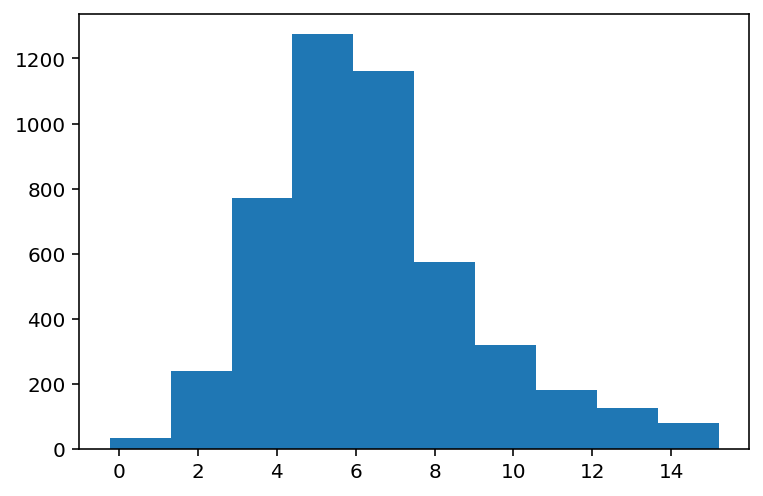

In [20]:
avg_card_foreigner_data = card_foreigner_df.groupby(['행정동명', 'year', 'week_index', 'is_holiday']).sum()['USE_AMT'].to_dict()
avg_card_foreigner_data = {key: value / week_info_days[key[1], key[2], key[3]] for key, value in avg_card_foreigner_data.items()}

plt.hist(np.log(list(avg_card_foreigner_data.values())))
plt.show()

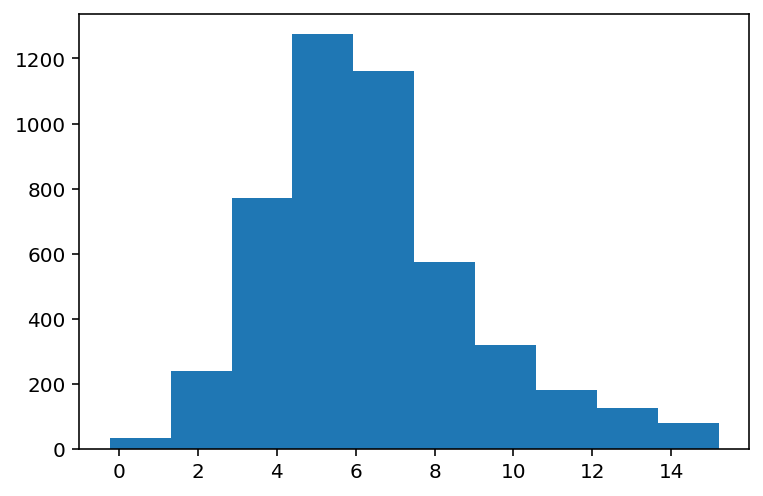

In [21]:
avg_card_foreigner_data = card_foreigner_df.groupby(['행정동명', 'year', 'week_index', 'is_holiday']).sum()['USE_AMT'].to_dict()
avg_card_foreigner_data = {key: value / week_info_days[key[1], key[2], key[3]] for key, value in avg_card_foreigner_data.items()}

plt.hist(np.log(list(avg_card_foreigner_data.values())))
plt.show()

In [22]:
card_resident_df = pd.read_pickle('2020빅콘테스트 문제데이터(혁신아이디어분야)/02_카드매출데이터(신한카드)/card_resident_df.pkl')
attach_week_info_into_df(card_resident_df, 'STD_DD')
card_resident_df['지역'], card_resident_df['행정동명'] = zip(*[convert_dong_code_to_name(gu, dong) 
                                                      for gu, dong in zip(card_resident_df['GU_CD'], card_resident_df['DONG_CD'])])
card_resident_df['카테고리'] = [reverse_card_cat_group[cat] for cat in card_resident_df['MCT_CAT_CD']]
card_resident_df.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,is_holiday,week_index,year,지역,행정동명,카테고리
0,20190201,110,517,10,F,25,11,595,False,0,2019,대구 중구,동인동,숙박
1,20190201,110,517,10,F,50,5,243,False,0,2019,대구 중구,동인동,숙박
2,20190201,110,517,10,F,55,5,27,False,0,2019,대구 중구,동인동,숙박
3,20190201,110,517,10,M,20,11,243,False,0,2019,대구 중구,동인동,숙박
4,20190201,110,517,10,M,25,11,433,False,0,2019,대구 중구,동인동,숙박


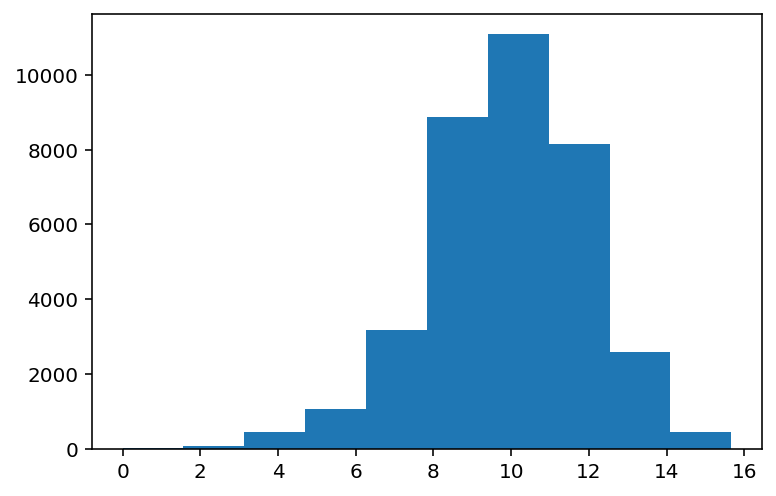

In [23]:
avg_card_resident_dict = card_resident_df.groupby(['행정동명', 'year', 'week_index', 'is_holiday']).sum()['USE_AMT'].to_dict()
avg_card_resident_dict.update(card_resident_df.groupby(['행정동명', '카테고리', 'year', 'week_index', 'is_holiday']).sum()['USE_AMT'].to_dict())

avg_card_resident_dict = {key: value / week_info_days[key[-3], key[-2], key[-1]] for key, value in avg_card_resident_dict.items()}

plt.hist(np.log(list(avg_card_resident_dict.values())))
plt.show()

In [24]:
lines = []

seoul_corona_holiday = [week_corona_dict[j+1, False, 'Seoul']['max_new_conformed_7days'] for j in range(17)]
seoul_corona_workday = [week_corona_dict[j+1, False, 'Seoul']['max_new_conformed_7days'] for j in range(17)]

seoul_corona = seoul_corona_holiday + seoul_corona_workday
seoul_corona_log = log_transform_custom(seoul_corona)
is_holiday = [1] * 17 + [0] * 17

for dong_name in seoul_dong_names:
    card_changes_holiday = [avg_card_resident_dict[dong_name, 2020, i, True] / avg_card_resident_dict[dong_name, 2019, i, True]
                            for i in range(17)]
    
    card_changes_workday = [avg_card_resident_dict[dong_name, 2020, i+1, False] / avg_card_resident_dict[dong_name, 2019, i+1, False] 
                            for i in range(17)]
    
    x = sm.add_constant(np.vstack((seoul_corona_log, is_holiday)).T)
    y = card_changes_holiday + card_changes_workday
    
    model = sm.OLS(y, x)
    results = model.fit()
    
    lines.append([dong_name, 
                  results.params[0], results.params[1], results.params[2], 
                  results.tvalues[0], results.tvalues[1], results.tvalues[2]])
    
    for cat_name in card_categories:
        card_changes_holiday = [avg_card_resident_dict.get((dong_name, cat_name, 2020, i, True), 0) 
                                / avg_card_resident_dict.get((dong_name, cat_name, 2019, i, True), 1)
                                for i in range(17)]

        card_changes_workday = [avg_card_resident_dict.get((dong_name, cat_name, 2020, i+1, False), 0) 
                                / avg_card_resident_dict.get((dong_name, cat_name, 2019, i+1, False), 1) 
                                for i in range(17)]
    
        x = sm.add_constant(np.vstack((seoul_corona_log, is_holiday)).T)
        y = card_changes_holiday + card_changes_workday

        model = sm.OLS(y, x)
        results = model.fit()
        
        lines[-1].extend([results.params[0], results.params[1], results.params[2], 
                          results.tvalues[0], results.tvalues[1], results.tvalues[2]])

C:\Users\eyshi\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


In [25]:
daegu_corona_holiday = [week_corona_dict[j+1, False, 'Daegu']['max_new_conformed_7days'] for j in range(17)]
daegu_corona_workday = [week_corona_dict[j+1, False, 'Daegu']['max_new_conformed_7days'] for j in range(17)]

daegu_corona = daegu_corona_holiday + daegu_corona_workday
daegu_corona_log = log_transform_custom(daegu_corona)
is_holiday = [1] * 17 + [0] * 17

for dong_name in daegu_dong_names:
    card_changes_holiday = [avg_card_resident_dict[dong_name, 2020, i, True] / avg_card_resident_dict[dong_name, 2019, i, True]
                            for i in range(17)]
    
    card_changes_workday = [avg_card_resident_dict[dong_name, 2020, i+1, False] / avg_card_resident_dict[dong_name, 2019, i+1, False] 
                            for i in range(17)]
    
    x = sm.add_constant(np.vstack((daegu_corona_log, is_holiday)).T)
    y = card_changes_holiday + card_changes_workday
    
    model = sm.OLS(y, x)
    results = model.fit()
    
    lines.append([dong_name, 
                  results.params[0], results.params[1], results.params[2], 
                  results.tvalues[0], results.tvalues[1], results.tvalues[2]])
    
    for cat_name in card_categories:
        card_changes_holiday = [avg_card_resident_dict.get((dong_name, cat_name, 2020, i, True), 0) 
                                / avg_card_resident_dict.get((dong_name, cat_name, 2019, i, True), 1)
                                for i in range(17)]

        card_changes_workday = [avg_card_resident_dict.get((dong_name, cat_name, 2020, i+1, False), 0) 
                                / avg_card_resident_dict.get((dong_name, cat_name, 2019, i+1, False), 1) 
                                for i in range(17)]
        
        x = sm.add_constant(np.vstack((daegu_corona_log, is_holiday)).T)
        y = card_changes_holiday + card_changes_workday

        model = sm.OLS(y, x)
        results = model.fit()

        lines[-1].extend([results.params[0], results.params[1], results.params[2], 
                          results.tvalues[0], results.tvalues[1], results.tvalues[2]])

C:\Users\eyshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [26]:
result_df = pd.DataFrame(lines, columns=['dong_name', 'const_coef', 'confirmed_coef', 'holiday_coef', 'const_tval', 'confirmed_tval', 'holiday_tval'] + ['%s_%s' % (cat_name, col_name) for cat_name in card_categories for col_name in ['const_coef', 'confirmed_coef', 'holiday_coef', 'const_tval', 'confirmed_tval', 'holiday_tval']])
result_df.head()

,dong_name,const_coef,confirmed_coef,holiday_coef,const_tval,confirmed_tval,holiday_tval,숙박_const_coef,숙박_confirmed_coef,숙박_holiday_coef,...,보건위생 및 수리 등 서비스_holiday_coef,보건위생 및 수리 등 서비스_const_tval,보건위생 및 수리 등 서비스_confirmed_tval,보건위생 및 수리 등 서비스_holiday_tval,요식업소_const_coef,요식업소_confirmed_coef,요식업소_holiday_coef,요식업소_const_tval,요식업소_confirmed_tval,요식업소_holiday_tval
0,소공동,0.878068,-0.005467,-0.086042,14.584847,-0.237792,-2.270126,0.865314,-0.039035,-0.132397,...,0.170366,3.147306,-0.023371,1.382067,0.977213,-0.016792,-0.049293,16.419920,-0.738928,-1.315629
1,회현동,0.977139,-0.053435,-0.050530,11.591980,-1.660095,-0.952183,1.053816,-0.199531,0.117790,...,0.116264,5.934674,-1.515315,1.228199,0.907402,-0.076435,-0.213657,13.088363,-2.887255,-4.895207
2,명동,0.832278,-0.018262,-0.172874,9.883052,-0.567892,-3.260763,0.464976,-0.043576,-0.039617,...,-0.041506,10.642861,-1.769375,-0.904183,0.818167,-0.050285,-0.217241,14.305794,-2.302563,-6.033637
3,필동,0.921583,-0.102099,-0.011346,11.394872,-3.305985,-0.222833,0.940692,-0.195847,-0.147826,...,-0.125852,6.277003,-1.562569,-1.153302,0.985521,-0.121755,-0.060881,9.611232,-3.109612,-0.943115
4,장충동,0.780567,-0.071273,-0.000139,8.589811,-2.054012,-0.002424,0.987231,-0.091998,-0.041962,...,2.576234,0.634176,0.044615,2.369662,0.886635,-0.046441,-0.047328,9.943042,-1.363893,-0.843072


## 2019 신용카드매출 지역특성

### 외국인/토탈 매출 비율

In [27]:
foreigner_amount = card_foreigner_df.groupby(['year', '행정동명']).sum()['USE_AMT'].to_dict()
resident_amount = card_resident_df.groupby(['year', '행정동명']).sum()['USE_AMT'].to_dict()

In [28]:
lines = []

for dong_name in seoul_dong_names + daegu_dong_names:
    foreigner_ratio = foreigner_amount[2019, dong_name] / (foreigner_amount[2019, dong_name] + resident_amount[2019, dong_name])
    lines.append((dong_name, foreigner_ratio))

In [29]:
temp_df = pd.DataFrame(lines, columns=['dong_name', 'foreigner_amount_ratio'])
temp_df.head()

,dong_name,foreigner_amount_ratio
0,소공동,0.372347
1,회현동,0.195381
2,명동,0.367965
3,필동,0.084397
4,장충동,0.614247


In [30]:
result_df = pd.merge(result_df, temp_df, how='inner', left_on='dong_name', right_on='dong_name')

In [31]:
result_df.columns

Index(['dong_name', 'const_coef', 'confirmed_coef', 'holiday_coef',
       'const_tval', 'confirmed_tval', 'holiday_tval', '숙박_const_coef',
       '숙박_confirmed_coef', '숙박_holiday_coef', '숙박_const_tval',
       '숙박_confirmed_tval', '숙박_holiday_tval', '레저문화취미_const_coef',
       '레저문화취미_confirmed_coef', '레저문화취미_holiday_coef', '레저문화취미_const_tval',
       '레저문화취미_confirmed_tval', '레저문화취미_holiday_tval',
       '도매, 소매 유통 전반_const_coef', '도매, 소매 유통 전반_confirmed_coef',
       '도매, 소매 유통 전반_holiday_coef', '도매, 소매 유통 전반_const_tval',
       '도매, 소매 유통 전반_confirmed_tval', '도매, 소매 유통 전반_holiday_tval',
       '연료/자동차_const_coef', '연료/자동차_confirmed_coef', '연료/자동차_holiday_coef',
       '연료/자동차_const_tval', '연료/자동차_confirmed_tval', '연료/자동차_holiday_tval',
       '의료기관_const_coef', '의료기관_confirmed_coef', '의료기관_holiday_coef',
       '의료기관_const_tval', '의료기관_confirmed_tval', '의료기관_holiday_tval',
       '보건위생 및 수리 등 서비스_const_coef', '보건위생 및 수리 등 서비스_confirmed_coef',
       '보건위생 및 수리 등 서비스_holiday_coef', 

### 2019 토탈 매출 금액 + 카테고리별 매출 금액

In [32]:
resident_amount = card_resident_df.groupby(['year', '행정동명', '카테고리']).sum()['USE_AMT'].to_dict()
resident_amount.update(card_resident_df.groupby(['year', '행정동명']).sum()['USE_AMT'].to_dict())

In [33]:
lines = []

for dong_name in seoul_dong_names + daegu_dong_names:
    lines.append([dong_name, np.log(resident_amount[2019, dong_name])])
    
    for cat_name in card_categories:
        amount = np.log(resident_amount.get((2019, dong_name, cat_name), 1))
                        
        lines[-1].append(amount)

In [34]:
temp_df = pd.DataFrame(lines, columns=['dong_name', 'card_amount'] + ['%s_card_amount'%cat_name for cat_name in card_categories])
temp_df.tail()

,dong_name,card_amount,숙박_card_amount,레저문화취미_card_amount,"도매, 소매 유통 전반_card_amount",연료/자동차_card_amount,의료기관_card_amount,보건위생 및 수리 등 서비스_card_amount,요식업소_card_amount
64,남산2동,16.070529,7.360740,11.441548,14.064115,12.098187,15.401847,13.738865,14.588840
65,남산3동,15.127994,0.000000,10.936939,14.115350,13.915869,12.280967,11.647045,13.680903
66,남산4동,16.228418,7.050989,11.843444,14.694516,15.337751,14.675728,12.999377,14.021920
67,대봉1동,17.440453,0.000000,13.780329,16.992372,13.636916,15.339601,13.283015,15.698208
68,대봉2동,14.603788,0.000000,11.033550,12.949492,11.852422,11.409319,10.780601,14.179045


In [35]:
result_df = pd.merge(result_df, temp_df, how='inner', left_on='dong_name', right_on='dong_name')

In [36]:
result_df.tail()

,dong_name,const_coef,confirmed_coef,holiday_coef,const_tval,confirmed_tval,holiday_tval,숙박_const_coef,숙박_confirmed_coef,숙박_holiday_coef,...,요식업소_holiday_tval,foreigner_amount_ratio,card_amount,숙박_card_amount,레저문화취미_card_amount,"도매, 소매 유통 전반_card_amount",연료/자동차_card_amount,의료기관_card_amount,보건위생 및 수리 등 서비스_card_amount,요식업소_card_amount
64,남산2동,1.091147,-0.101506,-0.063681,14.161679,-5.346767,-0.800187,26.398795,-3.787212,10.688462,...,-1.307466,0.002979,16.070529,7.360740,11.441548,14.064115,12.098187,15.401847,13.738865,14.588840
65,남산3동,0.961187,0.007940,0.065361,5.809185,0.194761,0.382448,0.000000,0.000000,0.000000,...,-2.341282,0.001433,15.127994,0.000000,10.936939,14.115350,13.915869,12.280967,11.647045,13.680903
66,남산4동,1.031965,-0.047297,-0.100072,16.362661,-3.043644,-1.536199,2.817447,7.492450,-23.588235,...,-2.121414,0.001611,16.228418,7.050989,11.843444,14.694516,15.337751,14.675728,12.999377,14.021920
67,대봉1동,0.836116,-0.057571,-0.068959,13.146863,-3.673923,-1.049773,0.000000,0.000000,0.000000,...,-2.749476,0.003758,17.440453,0.000000,13.780329,16.992372,13.636916,15.339601,13.283015,15.698208
68,대봉2동,0.940042,-0.096633,-0.156225,14.588945,-6.086569,-2.347331,0.000000,0.000000,0.000000,...,-1.954706,0.017738,14.603788,0.000000,11.033550,12.949492,11.852422,11.409319,10.780601,14.179045


In [37]:
result_df.to_pickle('2020빅콘테스트 문제데이터(혁신아이디어분야)/02_카드매출데이터(신한카드)/features_card.pkl')

# 물류 데이터

## 탄력성

In [38]:
delivery_cat_group = {
    '레저문화취미': [12, 16], # 도서/음반, 스포츠/레져
    '도매, 소매 유통 전반': [10, 13, 18, 19, 20], # 가구/인테리어, 디지털/가전, 출산/유가, 패션의류, 패션잡화
    '보건위생 및 수리 등 서비스': [15, 21], # 생활건강, 화장품/미용
    '요식업소': [17] # 식품
}

delivery_categories = list(delivery_cat_group.keys())
reverse_delivery_cat_group = {val:key for key, values in delivery_cat_group.items() for val in values}

In [39]:
delivery_df = pd.read_csv('2020빅콘테스트 문제데이터(혁신아이디어분야)/05_물류데이터(CJ올리브네트웍스)/2020 빅콘테스트_CJ올리브네트웍스_제공DB.csv')
delivery_df['카테고리'] = [reverse_delivery_cat_group[code] for code in delivery_df['DL_GD_LCLS_CD']]
delivery_df['date'] = delivery_df['DL_YMD'] + 20000000
attach_week_info_into_df(delivery_df, 'date')
delivery_df['INVC_CONT'] = [int(val.strip().replace(',', '')) for val in delivery_df[' INVC_CONT ']]
delivery_df.tail()

,DL_YMD,DL_GD_LCLS_NM,DL_GD_LCLS_CD,CTPV_NM,CTPV_CD,CTGG_NM,CTGG_CD,HDNG_NM,HDNG_CD,INVC_CONT,카테고리,date,is_holiday,week_index,year,INVC_CONT
156566,200531,패션의류,19,대구광역시,27,수성구,26,범물2동,662,22,"도매, 소매 유통 전반",20200531,True,17,2020,22
156567,200531,패션의류,19,서울특별시,11,중구,14,약수동,635,21,"도매, 소매 유통 전반",20200531,True,17,2020,21
156568,200531,패션잡화,20,대구광역시,27,수성구,26,범물2동,662,14,"도매, 소매 유통 전반",20200531,True,17,2020,14
156569,200531,패션잡화,20,서울특별시,11,노원구,35,상계6.7동,695,25,"도매, 소매 유통 전반",20200531,True,17,2020,25
156570,200531,화장품/미용,21,대구광역시,27,수성구,26,수성4가동,590,27,보건위생 및 수리 등 서비스,20200531,True,17,2020,27


In [40]:
avg_delivery_data = delivery_df.groupby(['HDNG_NM', '카테고리', 'year', 'week_index', 'is_holiday']).sum()['INVC_CONT'].to_dict()
avg_delivery_data = {key:value / week_info_days[key[2], key[3], key[4]] for key, value in avg_delivery_data.items()}

In [51]:
lines = []

seoul_corona_holiday = [week_corona_dict[j+1, False, 'Seoul']['max_new_conformed_7days'] for j in range(17)]
seoul_corona_workday = [week_corona_dict[j+1, False, 'Seoul']['max_new_conformed_7days'] for j in range(17)]

seoul_corona = [a+b for a, b in zip(seoul_corona_holiday, seoul_corona_workday)]
seoul_corona_log = log_transform_custom(seoul_corona)

for dong_name in seoul_dong_names:
    lines.append([dong_name])
    
    for cat_name in delivery_categories:
        deli_changes_holiday = [avg_delivery_data.get((dong_name, cat_name, 2020, i), 0)
                                / avg_delivery_data.get((dong_name, cat_name, 2019, i), 1)
                                for i in range(17)]

        deli_changes_workday = [avg_delivery_data.get((dong_name, cat_name, 2020, i+1, False), 0)
                                / avg_delivery_data.get((dong_name, cat_name, 2019, i+1, False), 1)
                                for i in range(17)]
        
        # 택배는 휴일 구분의 의미가 별로 없음
        deli_changes = [a+b for a, b in zip(deli_changes_holiday, deli_changes_workday)]
        
        x = sm.add_constant(seoul_corona_log)
        y = deli_changes

        model = sm.OLS(y, x)
        results = model.fit()
        
        lines[-1].extend([results.params[0], results.params[1],
                          results.tvalues[0], results.tvalues[1]])

C:\Users\eyshi\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


In [52]:
daegu_corona_holiday = [week_corona_dict[j+1, False, 'Daegu']['max_new_conformed_7days'] for j in range(17)]
daegu_corona_workday = [week_corona_dict[j+1, False, 'Daegu']['max_new_conformed_7days'] for j in range(17)]

daegu_corona = [a+b for a, b in zip(daegu_corona_holiday, daegu_corona_workday)]
daegu_corona_log = log_transform_custom(daegu_corona)

for dong_name in daegu_dong_names:
    lines.append([dong_name])
    
    for cat_name in delivery_categories:
        deli_changes_holiday = [avg_delivery_data.get((dong_name, cat_name, 2020, i), 0)
                                / avg_delivery_data.get((dong_name, cat_name, 2019, i), 1)
                                for i in range(17)]

        deli_changes_workday = [avg_delivery_data.get((dong_name, cat_name, 2020, i+1, False), 0)
                                / avg_delivery_data.get((dong_name, cat_name, 2019, i+1, False), 1)
                                for i in range(17)]
        
        # 택배는 휴일 구분의 의미가 별로 없음
        deli_changes = [a+b for a, b in zip(deli_changes_holiday, deli_changes_workday)]
        
        x = sm.add_constant(daegu_corona_log)
        y = deli_changes

        model = sm.OLS(y, x)
        results = model.fit()
        
        lines[-1].extend([results.params[0], results.params[1],
                          results.tvalues[0], results.tvalues[1]])

C:\Users\eyshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [54]:
result_df = pd.DataFrame(lines, columns=['dong_name'] + ['%s_%s' % (cat_name, col_name) for cat_name in delivery_categories for col_name in ['const_coef', 'confirmed_coef', 'const_tval', 'confirmed_tval']])
result_df.head()

,dong_name,레저문화취미_const_coef,레저문화취미_confirmed_coef,레저문화취미_const_tval,레저문화취미_confirmed_tval,"도매, 소매 유통 전반_const_coef","도매, 소매 유통 전반_confirmed_coef","도매, 소매 유통 전반_const_tval","도매, 소매 유통 전반_confirmed_tval",보건위생 및 수리 등 서비스_const_coef,보건위생 및 수리 등 서비스_confirmed_coef,보건위생 및 수리 등 서비스_const_tval,보건위생 및 수리 등 서비스_confirmed_tval,요식업소_const_coef,요식업소_confirmed_coef,요식업소_const_tval,요식업소_confirmed_tval
0,소공동,1.002749,0.007441,8.179591,0.191069,1.088481,-0.050399,10.500325,-1.530533,1.098942,-0.012927,13.545909,-0.501625,1.016834,0.030100,10.067395,0.938142
1,회현동,1.264952,-0.063961,3.550874,-0.565215,1.067290,-0.053981,8.962796,-1.427050,1.152791,-0.027691,16.972955,-1.283471,1.222649,-0.020814,16.184334,-0.867315
2,명동,0.914905,0.026246,4.426487,0.399753,1.212507,-0.100079,7.101395,-1.845181,1.123431,-0.088295,7.383197,-1.826720,1.254766,-0.075146,14.219748,-2.680838
3,필동,1.182405,-0.027842,6.111975,-0.453057,1.036406,-0.005009,4.734715,-0.072037,1.171947,-0.016998,11.850907,-0.541113,1.068615,0.033506,9.464603,0.934191
4,장충동,1.090445,0.020310,5.176696,0.303527,0.895537,0.033515,7.330462,0.863629,0.408372,0.316171,0.757383,1.845945,1.002354,0.063092,7.133424,1.413480


## 2019 데이터

In [57]:
delivery_count = delivery_df.groupby(['year', 'HDNG_NM', '카테고리']).sum()['INVC_CONT'].to_dict()

In [58]:
lines = []

for dong_name in seoul_dong_names + daegu_dong_names:
    lines.append([dong_name])
    
    for cat_name in delivery_categories:
        amount = np.log(delivery_count.get((2019, dong_name, cat_name), 1))
                        
        lines[-1].append(amount)

In [59]:
temp_df = pd.DataFrame(lines, columns=['dong_name'] + ['%s_count'%cat_name for cat_name in delivery_categories])
temp_df.tail()

,dong_name,레저문화취미_count,"도매, 소매 유통 전반_count",보건위생 및 수리 등 서비스_count,요식업소_count
64,남산2동,7.719130,9.286004,9.206935,8.708805
65,남산3동,7.930206,9.641798,10.268165,8.957768
66,남산4동,8.364042,10.040637,9.839909,9.456028
67,대봉1동,8.493925,10.050182,9.797849,9.388821
68,대봉2동,7.186901,8.568456,8.349248,8.044305


In [60]:
result_df = pd.merge(result_df, temp_df, how='inner', left_on='dong_name', right_on='dong_name')

In [61]:
result_df.head()

,dong_name,레저문화취미_const_coef,레저문화취미_confirmed_coef,레저문화취미_const_tval,레저문화취미_confirmed_tval,"도매, 소매 유통 전반_const_coef","도매, 소매 유통 전반_confirmed_coef","도매, 소매 유통 전반_const_tval","도매, 소매 유통 전반_confirmed_tval",보건위생 및 수리 등 서비스_const_coef,...,보건위생 및 수리 등 서비스_const_tval,보건위생 및 수리 등 서비스_confirmed_tval,요식업소_const_coef,요식업소_confirmed_coef,요식업소_const_tval,요식업소_confirmed_tval,레저문화취미_count,"도매, 소매 유통 전반_count",보건위생 및 수리 등 서비스_count,요식업소_count
0,소공동,1.002749,0.007441,8.179591,0.191069,1.088481,-0.050399,10.500325,-1.530533,1.098942,...,13.545909,-0.501625,1.016834,0.030100,10.067395,0.938142,9.643810,10.868016,10.676947,10.345445
1,회현동,1.264952,-0.063961,3.550874,-0.565215,1.067290,-0.053981,8.962796,-1.427050,1.152791,...,16.972955,-1.283471,1.222649,-0.020814,16.184334,-0.867315,9.245418,10.923742,10.739631,10.344448
2,명동,0.914905,0.026246,4.426487,0.399753,1.212507,-0.100079,7.101395,-1.845181,1.123431,...,7.383197,-1.826720,1.254766,-0.075146,14.219748,-2.680838,9.853562,11.095438,10.994118,10.572035
3,필동,1.182405,-0.027842,6.111975,-0.453057,1.036406,-0.005009,4.734715,-0.072037,1.171947,...,11.850907,-0.541113,1.068615,0.033506,9.464603,0.934191,9.037296,10.186069,9.949655,9.722505
4,장충동,1.090445,0.020310,5.176696,0.303527,0.895537,0.033515,7.330462,0.863629,0.408372,...,0.757383,1.845945,1.002354,0.063092,7.133424,1.413480,8.459352,9.992505,9.632204,9.435003


In [62]:
result_df.to_pickle('2020빅콘테스트 문제데이터(혁신아이디어분야)/05_물류데이터(CJ올리브네트웍스)/features_delivery.pkl')